

# How COVID has influenced Bike use in the Bay Area
## by Grant Glass

## Investigation Overview

>In this investigation, I wanted to look at how the COVID19 pandemic might have reduced or increased ridership in the Lyft Bay Wheels program. The main focus was on trip duration, trip distance, and types of riders.

## Dataset Overview

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. I will merge both January, Februrary, and March's data together. The dataset includes the following features : Trip Duration in seconds , Start Time and Date , End Time and Date , Start Station ID , Start Station Name , Start Station Latitude , Start Station Longitude , End Station ID , End Station Name, End Station Latitude , End Station Longitude , Bike ID , User Type , and  Rental Access Method. The dataset is the result of merging 4 files(January, February, March, April (2020)). It has 23 features and 989,266 rows.

>Pulling the data down and looking at it on Excel shows us that

>January's Data: 295855 trips
>February's Data: 432355 trips
>March's Data: 176800 trips
>April's Data: 84260 trips

>We see that there is a clear downturn in April on overall trips.
>But what can the data tell us about the behaviors of the users of Bay Wheels?

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import matplotlib.style as style 
from matplotlib.collections import LineCollection
import seaborn as sb
import os
import matplotlib.image as mpimg

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# merge all the files together
currentDir = os.getcwd()
path = currentDir+'/data/'
text_files = os.listdir(path)

# loop to get all files together
file_list = []
for text_file in text_files:
    filename = path+text_file
    df = pd.read_csv(filename)
    file_list.append(df)
df_merge = pd.concat(file_list) 
df_merge.head()


,bike_id,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,ended_at,member_casual,rental_access_method,ride_id,rideable_type,start_station_id,start_station_latitude,start_station_longitude,start_station_name,start_time,started_at,user_type
0,13052.0,83118.0,400.0,37.804272,-122.433537,Buchanan St at North Point St,2020-02-01 14:29:06.2630,NaN,NaN,NaN,NaN,NaN,400.0,37.804272,-122.433537,Buchanan St at North Point St,2020-01-31 15:23:47.7330,NaN,Customer
1,12235.0,68239.0,99.0,37.767037,-122.415443,Folsom St at 15th St,2020-02-01 10:37:51.0000,NaN,NaN,NaN,NaN,NaN,99.0,37.767037,-122.415443,Folsom St at 15th St,2020-01-31 15:40:31.6160,NaN,Subscriber
2,12822.0,55407.0,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2020-02-01 09:11:44.3170,NaN,NaN,NaN,NaN,NaN,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2020-01-31 17:48:16.6350,NaN,Customer
3,11705.0,54929.0,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2020-02-01 09:08:32.6340,NaN,NaN,NaN,NaN,NaN,197.0,37.808848,-122.249680,El Embarcadero at Grand Ave,2020-01-31 17:53:03.4130,NaN,Customer
4,3673.0,55700.0,371.0,37.802746,-122.413579,Lombard St at Columbus Ave,2020-02-01 08:40:53.6460,NaN,NaN,NaN,NaN,NaN,12.0,37.796389,-122.394586,Pier 1/2 at The Embarcadero,2020-01-31 17:12:33.4600,NaN,Customer


In [4]:
#Let's first make a consistent id column
df_merge['id'] = df_merge['bike_id'].fillna(df_merge['ride_id'])
df_merge.drop(['bike_id', 'ride_id'], axis=1, inplace=True)
df_merge.id = df_merge.id.astype(str)
#Let's drop uneeded categories. Some of these like ridable_type and rental_access_method are completely different variables.
#user_type and member_casual are essentially the same thing. let's combine them.
df_merge.drop(['end_station_id', 'end_station_name', 'start_station_id', 'start_station_name', 'rideable_type','rental_access_method' ], axis=1, inplace=True)
df_merge['type_of_user'] = df_merge['user_type'].fillna(df_merge['member_casual'])
df_merge.drop(['user_type', 'member_casual'], axis=1, inplace=True)
#Let's set the user types to be consistent with Jan-March and April.
df_merge.type_of_user = df_merge.type_of_user.astype(str)
df_merge['type_of_user'] = df_merge['type_of_user'].str.replace('casual', 'Customer')
df_merge['type_of_user'] = df_merge['type_of_user'].str.replace('member', 'Subscriber')
#Let's calculate the duration in seconds of the April Data
df_merge['started_at'] = pd.to_datetime(df_merge['started_at'])
df_merge['ended_at'] = pd.to_datetime(df_merge['ended_at'])
df_merge['diff_sec'] = df_merge['ended_at'] - df_merge['started_at']
df_merge['diff_sec']=df_merge['diff_sec']/np.timedelta64(1,'s')
#Normalize format of date and time
df_merge['started_at'] = df_merge['started_at'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_merge['ended_at'] = df_merge['ended_at'].dt.strftime('%Y-%m-%d %H:%M:%S')
df_merge['started_time'] = df_merge['start_time'].fillna(df_merge['started_at'])
df_merge['ended_time'] = df_merge['end_time'].fillna(df_merge['ended_at'])
df_merge.drop(['started_at', 'ended_at'], axis=1, inplace=True)
df_merge.drop(['start_time', 'end_time'], axis=1, inplace=True)
df_merge['duration_seconds'] = df_merge['duration_sec'].fillna(df_merge['diff_sec'])
df_merge.drop(['duration_sec', 'diff_sec'], axis=1, inplace=True)
#Calc minutes
df_merge['duration_min'] = df_merge['duration_seconds'] / 60
df_merge['duration_min'].value_counts()
#Extract Date Data
df_merge['start_time'] = pd.to_datetime(df_merge['started_time'])
df_merge['start_year'] = df_merge['start_time'].dt.year
df_merge['start_month'] = df_merge['start_time'].dt.month
df_merge['start_day'] = df_merge['start_time'].dt.day
#create month/day column
df_merge['timing'] = df_merge['start_time'].dt.strftime('%m%d')
#eliminate any missing data that is zero
df_merge = df_merge[df_merge.start_station_latitude != 0]
df_merge = df_merge[df_merge.end_station_latitude != 0]

In [5]:
#from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas/29546836#29546836
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [6]:
#use this to calculate distance between start and end points. 
df_merge['distance'] = haversine_np(df_merge['start_station_longitude'],df_merge['start_station_latitude'],df_merge['end_station_longitude'],df_merge['end_station_latitude'])


## Trip Duration Distribution in Minutes

>Looking at the duration of the trips in mintues instead of seconds gave me a much clearer looking distribution, which is clearly normal distribution. The average trip took about 15 minutes, which seems to indicate either people use the bikes if they live or work close together or alternatively, they use these bikes for small trips that they would normally use a taxi for, but do not want to pay as much money. The bike riding pattern seems to be related to small trips. 

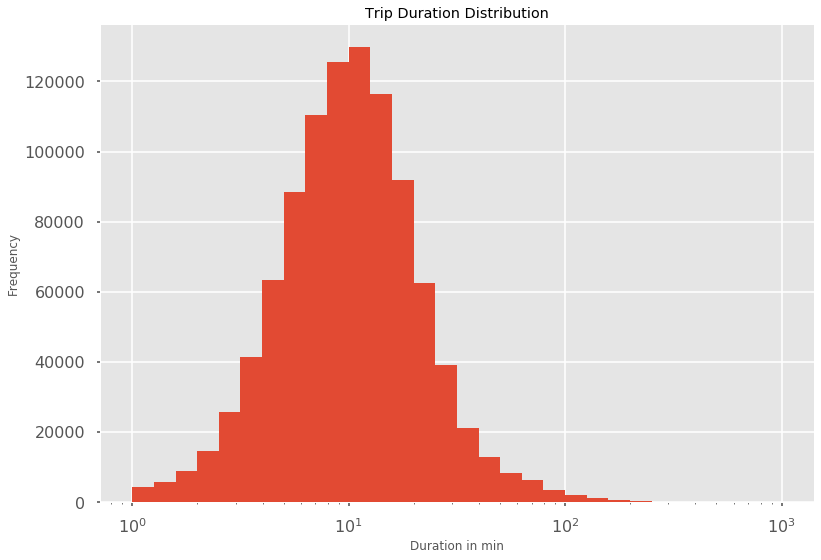

In [8]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
bin_edges = 10**np.arange(0 , 3+0.1 , 0.1)
ticks =  [ 0.1 , 0.3 , 1 , 3, 10, 30, 100, 300]
labels = ['{}'.format(v) for v in ticks]
plt.hist(data = df_merge , x = 'duration_min' , bins = bin_edges);
plt.xticks(ticks,labels);
plt.xlabel('Duration in min');
plt.xscale('log');
plt.title('Trip Duration Distribution')
plt.ylabel('Frequency');

## Trip Duration in Minutes Against types of Users by Month

> Next, I wanted to explore a little more in depth analysis of what kind of users were riding longer than others and if the COVID Pandemic changed the patterns seen in the begining of the year. Clearly, the users that use the bike for the longest period of time were the subscribers or members. These were people that do not just use the bikes for small trips, but they depend on these bikes as their primary mode of transportation, as we can see in the consistent duration for the first three months of the year. However, in April, we see that the customers are the ones who dominate the trip durations. Some ever kept their bike for a whole month. These users took advantage of a special promotion for healthcare workers, where they could ride as often or as long as they wanted. Because of the concern of sharing bikes, many of these workers just kept the same bike for the duration of use, so no one else could potentially infect the bike. 

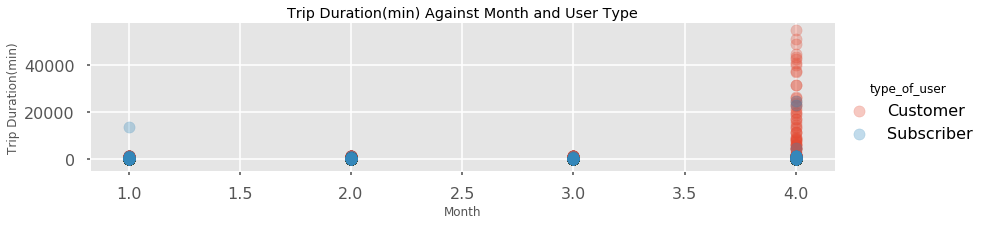

In [9]:
g = sb.FacetGrid(data =  df_merge, hue = 'type_of_user', aspect=4)
g.map(plt.scatter, 'start_month','duration_min', alpha = .3)
g.add_legend()
plt.title('Trip Duration(min) Against Month and User Type')
plt.xlabel('Month')
plt.ylabel('Trip Duration(min)');

## Distance Traveled

>Next, I wanted to look at distance and wondered where people were going on these bikes. I looked at the spacial data and brought in open street maps to see where exactly people were taking these bikes. We can see three key areas in the map, the East Bay, San Franscisco, and San Jose. The spread of people traveling is much greater in the last two areas. 



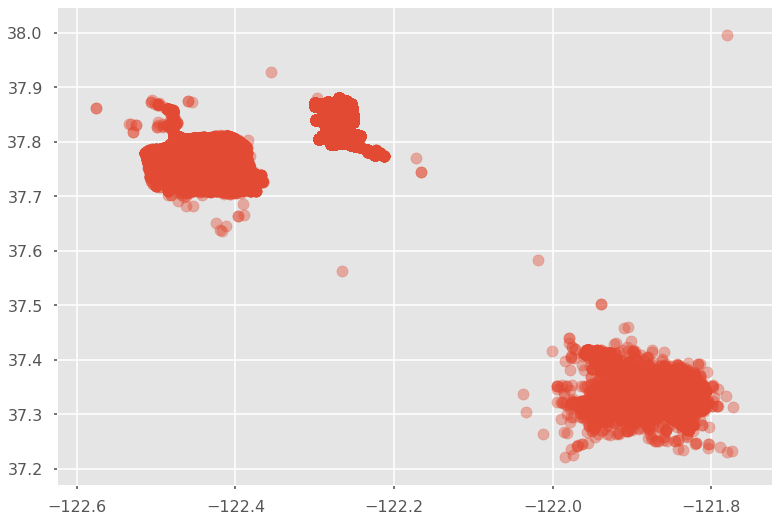

In [14]:
plt.scatter(data = df_merge , x="end_station_longitude", y="end_station_latitude", alpha=0.4)

#It is difficult to visualize this data in Python with connecting all of the points together, so here is the data placed in ArcGIS
![East Bay](east.png)
![San Jose](south.png)
![Central](central.png)

## Distance Traveled in km each month

>There is much more distance covered in March and April, with some of the largest distances from those users who kept the bike, but there was a nice uptick in the amount of people taking 20 minute rides, which was greater than the mean of the overall distribution.

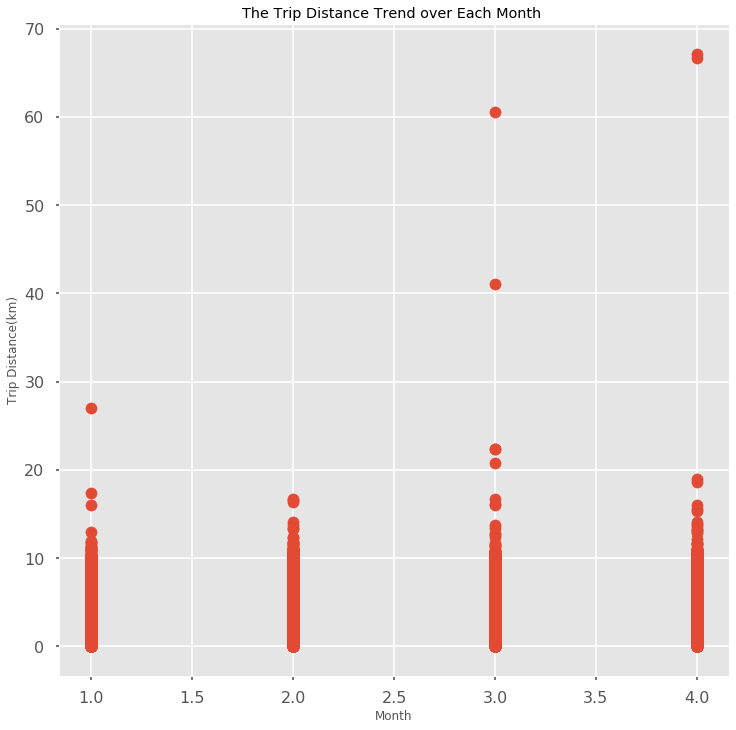

In [16]:
plt.figure(figsize = [12,12]) 
plt.scatter(data = df_merge , x = 'start_month' , y = 'distance', )
plt.title('The Trip Distance Trend over Each Month ')
plt.xlabel('Month')
plt.ylabel('Trip Distance(km)');

## Distance in km against user type

>We can see that it is customers, not subscribers that travel the most distance. Since it is much more expensive to ride this far, we can see the uptick in April caused by this. But what about Janurary and February? Since the new year often brings new ways for people to stay fit, it is probably because some people were trying out biking to work and could not do it anymore in March. 

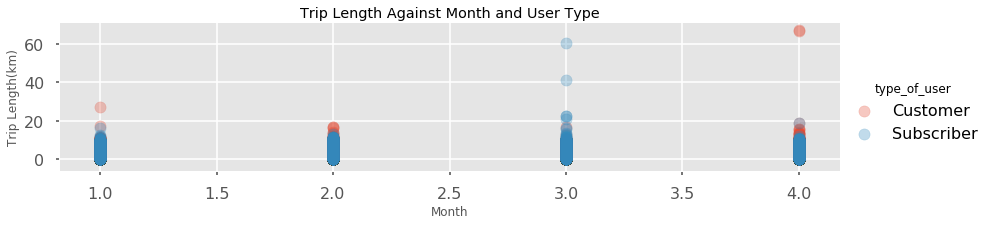

In [18]:
g = sb.FacetGrid(data =  df_merge, hue = 'type_of_user', aspect=4)
g.map(plt.scatter, 'start_month','distance', alpha = .3)
g.add_legend()
plt.title('Trip Length Against Month and User Type')
plt.xlabel('Month')
plt.ylabel('Trip Length(km)');